# hs-code-nlp-classifier-cl

## Configuraciones

In [1]:
import sys
import json
import inspect
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import torch
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import transformers
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
)
import gc
import os
import seaborn as sns
from datetime import datetime

import joblib
import time

import re
import unicodedata




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = Path('/content/drive/MyDrive/')
DIR_RAW_DATA = drive_path / 'hs-code-nlp-classifier-cl/data/raw/'
DIR_IMAGES = drive_path / 'hs-code-nlp-classifier-cl/outputs/images/'
DIR_MODELS = drive_path / 'hs-code-nlp-classifier-cl/models/'
DIR_LOG = drive_path / 'hs-code-nlp-classifier-cl/outputs/log/'
DATASET_FILENAME = "mercancias20260111_004347.csv"


In [ ]:
# Constantes
SEED = 42
COL_TEXT = "mercancia_descripcion"
COL_CODE = "partida_arancelaria_codigo"
COL_LEN = "len_descripcion"

TEST_MODE = False


In [ ]:
# Guarda la configuración actual de formato de flotantes
original_float_format = pd.get_option('display.float_format')

# Establece el formato de flotantes a 2 decimales para una salida más limpia
pd.set_option('display.float_format', '{:.2f}'.format)


# Restaura la configuración original de formato de flotantes
#pd.set_option('display.float_format', original_float_format)


## Arquitectura

```text
    Entrada: descripción del producto
                ↓
[Filtro IN/OUT — BERT binario compartido]
                ↓
   ┌───────────────────────────────┐
   ↓                               ↓
[SVM multiclase]           [BERT multiclase]
        ↓                          ↓
   Código HS                  Código HS
        ↓                          ↓
            [Revisión Expeta]
```

## Clasificación multiclase

### Dataset multiclase para la capa IN

In [ ]:
# Cargar clases objetivo desde el artefacto generado
path_clases_in = Path(DIR_LOG) / ("clases_ins_test.csv" if TEST_MODE else "clases_ins.csv")
clases_objetivo = pd.read_csv(path_clases_in)["clases_objetivo"].astype(str).tolist()
clases_set = set(clases_objetivo)

df_mc = df_in_top_k.copy()
df_mc[COL_CODE] = df_mc[COL_CODE].astype(str).str.strip()
df_mc = df_mc[df_mc[COL_CODE].isin(clases_set)].copy()

# Etiqueta multiclase: el código HS dentro del set objetivo
df_mc["label_code"] = df_mc[COL_CODE].astype(str)

print("[INFO] registros IN (multiclase):", len(df_mc))
print("[INFO] clases:", df_mc["label_code"].nunique())
print(df_mc["label_code"].value_counts().head(10))


[INFO] registros IN (multiclase): 4119753
[INFO] clases: 430
label_code
30061059    126200
90213990    124172
90189089    109399
33041000    107284
84439990     96314
33042000     81872
84314320     75728
33049990     74860
33059090     70094
84733000     57488
Name: count, dtype: int64


### Split estratificado por código HS

In [ ]:
SEED = int(SEED)

# (Opcional) cap por clase para limitar tamaño y evitar sesgos extremos
N_PER_CLASS_MC = 2000
df_mc_bal = df_mc.groupby("label_code", group_keys=False).apply(
    lambda x: x.sample(min(len(x), N_PER_CLASS_MC), random_state=SEED)
).reset_index(drop=True)

# Split train/val/test estratificado por label_code
df_trainval, df_test_mc = train_test_split(
    df_mc_bal,
    test_size=0.20,
    stratify=df_mc_bal["label_code"],
    random_state=SEED
)
df_train_mc, df_val_mc = train_test_split(
    df_trainval,
    test_size=0.10 / 0.80,  # val=10% total
    stratify=df_trainval["label_code"],
    random_state=SEED
)

print("[INFO] train_mc:", len(df_train_mc), "| val_mc:", len(df_val_mc), "| test_mc:", len(df_test_mc))
print("[INFO] clases train:", df_train_mc["label_code"].nunique())


/tmp/ipython-input-3385288075.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mc_bal = df_mc.groupby("label_code", group_keys=False).apply(


[INFO] train_mc: 602000 | val_mc: 86000 | test_mc: 172000
[INFO] clases train: 430


## Modelo SVM multiclase

In [ ]:
TEST_MODE = False


### Parámetros

In [ ]:
print("[INFO] TEST_MODE:", TEST_MODE)

# Parámetros TF-IFD
NGRAM_RANGE=(1,2)
MIN_DF=5
MAX_DF = 0.95
MAX_FEATURES=300000
SUBLINEAR_TF=True
STRIP_ACCENTS = "unicode"
TFIDF_DTYPE = np.float32

# Parámetros LinearSVC
SVM_C = 1.0
SVM_MAX_ITER = 5000

# Umbral de abstención (calibrar)
TAU_MARGIN = 0.5  # valor inicial, calibrar en val

if TEST_MODE:
    NGRAM_RANGE = (1,1)
    MIN_DF = 3
    MAX_FEATURES = 120000
    print("[INFO] SVM parameters ajustados para modo TEST.")

# Artefactos
SVM_DIR = Path(DIR_MODELS) / ("svm_multiclass_test" if TEST_MODE else "svm_multiclass_final")
SVM_DIR.mkdir(parents=True, exist_ok=True)

print("[INFO] SVM_DIR:", SVM_DIR)
print("[INFO] TF-IDF:", {
    "ngram_range": NGRAM_RANGE, "min_df": MIN_DF, "max_df": MAX_DF,
    "max_features": MAX_FEATURES, "sublinear_tf": SUBLINEAR_TF,
    "strip_accents": STRIP_ACCENTS, "dtype": str(TFIDF_DTYPE)
})
print("[INFO] LinearSVC:", {"C": SVM_C, "max_iter": SVM_MAX_ITER})


[INFO] TEST_MODE: False
[INFO] SVM_DIR: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/svm_multiclass_final
[INFO] TF-IDF: {'ngram_range': (1, 2), 'min_df': 5, 'max_df': 0.95, 'max_features': 300000, 'sublinear_tf': True, 'strip_accents': 'unicode', 'dtype': "<class 'numpy.float32'>"}
[INFO] LinearSVC: {'C': 1.0, 'max_iter': 5000}


### Preprocesamiento

In [ ]:
def preprocesar_texto_svm(texto: str) -> str:
    if texto is None:
        return ""
    t = str(texto)

    # Normalizar unicode (acentos y símbolos consistentes)
    t = unicodedata.normalize("NFKC", t)

    # Minúsculas
    t = t.lower()

    # Reemplazar saltos de línea y tabs por espacio
    t = re.sub(r"[\r\n\t]+", " ", t)

    # Colapsar espacios múltiples
    t = re.sub(r"\s{2,}", " ", t).strip()

    # Opcional: eliminar caracteres no imprimibles
    #t = re.sub(r"[^\x20-\x7EáéíóúñüÁÉÍÓÚÑÜ]", " ", t)
    return t

# Para SVM debe usarse SIEMPRE la misma función
def prep_text_series_svm(s, name=""):
    print(f"[INFO] Preprocesando texto SVM: {name}")
    print(" - n:", len(s), "| nulls:", int(s.isna().sum()))

    t0 = time.time()
    out = s.fillna("").astype(str).map(preprocesar_texto_svm)
    dt = time.time() - t0

    empty = int((out.str.len() == 0).sum())
    avg_len = float(out.str.split().map(len).mean())

    print(f" - empty_after: {empty} | avg_tokens~: {avg_len:.1f} | time: {dt:.2f}s")
    return out


#### Preparación TRAIN y VALIDATION

In [ ]:
# Preparación TRAIN
print("[INFO] Construir X/y con prints y checks")
SVM_X_train = prep_text_series_svm(df_train_mc[COL_TEXT], "train")
SVM_y_train = df_train_mc["label_code"].astype(str)

SVM_X_val = prep_text_series_svm(df_val_mc[COL_TEXT], "val")
SVM_y_val = df_val_mc["label_code"].astype(str)

print("[INFO] clases:")
print(" - train unique:", SVM_y_train.nunique())
print(" - val   unique:", SVM_y_val.nunique())

print("[INFO] top-5 clases train:")
print(SVM_y_train.value_counts().head(5))

# Sanity: val no debería tener clases fuera de train
val_outside = set(SVM_y_val.unique()) - set(SVM_y_train.unique())
print("[INFO] clases en val fuera de train:", len(val_outside))
if len(val_outside) > 0:
    print(" - ejemplo:", list(val_outside)[:10])


[INFO] Construir X/y con prints y checks
[INFO] Preprocesando texto SVM: train
 - n: 602000 | nulls: 0
 - empty_after: 0 | avg_tokens~: 7.9 | time: 2.76s
[INFO] Preprocesando texto SVM: val
 - n: 86000 | nulls: 0
 - empty_after: 0 | avg_tokens~: 7.9 | time: 0.38s
[INFO] clases:
 - train unique: 430
 - val   unique: 430
[INFO] top-5 clases train:
label_code
84213190    1400
85044000    1400
90013010    1400
33059030    1400
62034290    1400
Name: count, dtype: int64
[INFO] clases en val fuera de train: 0


### Modelo Pipeline SVM (TF-IDF + LinearSVC)

In [56]:
print("[TRAIN] SVM Multiclase (TF-IDF + LinearSVC)")
tfidf = TfidfVectorizer(
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_FEATURES,
    sublinear_tf=SUBLINEAR_TF,
    strip_accents=STRIP_ACCENTS,
    dtype=TFIDF_DTYPE,
)

svm = LinearSVC(C=SVM_C, max_iter=SVM_MAX_ITER)


[TRAIN] SVM Multiclase (TF-IDF + LinearSVC)


### Entrenamiento

#### Fit TF-IDF + transform train

In [57]:
# Fit TF-IDF + transform train
t0 = time.time()
Xtr = tfidf.fit_transform(SVM_X_train)
dt = time.time() - t0
print(f"[TIME] TF-IDF fit_transform(train): {dt:.2f}s | shape={Xtr.shape}")


[TIME] TF-IDF fit_transform(train): 10.68s | shape=(602000, 79994)


#### TF-IDF transform

In [58]:
# Transform val
t0 = time.time()
Xva = tfidf.transform(SVM_X_val)
dt = time.time() - t0
print(f"[TIME] TF-IDF transform(val): {dt:.2f}s | shape={Xva.shape}")



[TIME] TF-IDF transform(val): 1.32s | shape=(86000, 79994)


#### Fit SVM

In [ ]:
# Fit SVM
t0 = time.time()
svm.fit(Xtr, SVM_y_train)
dt = time.time() - t0
print(f"[TIME] LinearSVC fit: {dt:.2f}s")


[TIME] LinearSVC fit: 16028.32s


### Validación

In [60]:
print("[INFO] VALIDATION – SVM Multiclase")

t0 = time.time()
SVM_y_pred = svm.predict(Xva)
dt = time.time() - t0

SVM_acc = accuracy_score(SVM_y_val, SVM_y_pred)
SVM_mf1 = f1_score(SVM_y_val, SVM_y_pred, average="macro")

print(f" - predict(val): {dt:.2f}s")
print(f" - accuracy(val):  {SVM_acc:.4f}")
print(f" - macro_f1(val):  {SVM_mf1:.4f}")

print("[INFO] classification_report (VAL):")
print(classification_report(SVM_y_val, SVM_y_pred, digits=4))


[INFO] VALIDATION – SVM Multiclase
 - predict(val): 0.76s
 - accuracy(val):  0.7931
 - macro_f1(val):  0.7994
[INFO] classification_report (VAL):
              precision    recall  f1-score   support

    10051090     0.9852    1.0000    0.9926       200
    17049000     0.9754    0.9900    0.9826       200
    18063100     0.9752    0.9850    0.9801       200
    18069000     0.9650    0.9650    0.9650       200
    19041000     1.0000    0.9950    0.9975       200
    19053100     0.9899    0.9800    0.9849       200
    19059000     0.9898    0.9750    0.9824       200
    20041000     0.9901    1.0000    0.9950       200
    21021000     0.9802    0.9900    0.9851       200
    21031000     0.9900    0.9900    0.9900       200
    21039020     0.9802    0.9900    0.9851       200
    21039090     0.9320    0.9600    0.9458       200
    21069000     0.9847    0.9650    0.9747       200
    22021010     1.0000    1.0000    1.0000       200
    22030000     0.9750    0.9750    0.9750

#### Backup

In [ ]:
print("[INFO] ")
suffix = "_test" if TEST_MODE else ""

# Guardar vectorizador + modelo por separado (más trazable)
joblib.dump(tfidf, SVM_DIR / f"tfidf{suffix}.joblib")
joblib.dump(svm,   SVM_DIR / f"linear_svc{suffix}.joblib")

# Guardar clases objetivo (ordenadas)
classes_sorted = sorted(SVM_y_train.unique())
pd.Series(classes_sorted, name="classes_in").to_csv(SVM_DIR / f"classes_in{suffix}.csv", index=False)

# Guardar métricas
metrics = {"val_accuracy": float(SVM_acc), "val_macro_f1": float(SVM_mf1)}
with open(SVM_DIR / f"metrics{suffix}.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

svm_n_classes = int(SVM_y_train.nunique())

# Guardar config / run meta
run_meta = {
    "timestamp": datetime.now().isoformat(),
    "test_mode": bool(TEST_MODE),
    "seed": int(SEED),
    "train_n": int(len(SVM_X_train)),
    "val_n": int(len(SVM_X_val)),
    "n_classes": svm_n_classes,
    "tfidf": {
        "ngram_range": list(NGRAM_RANGE),
        "min_df": int(MIN_DF),
        "max_df": float(MAX_DF),
        "max_features": int(MAX_FEATURES),
        "sublinear_tf": bool(SUBLINEAR_TF),
        "strip_accents": STRIP_ACCENTS,
        "dtype": "float32",
    },
    "svm": {"C": float(SVM_C), "max_iter": int(SVM_MAX_ITER), "model": "LinearSVC"},
}

with open(SVM_DIR / f"run_meta{suffix}.json", "w", encoding="utf-8") as f:
    json.dump(run_meta, f, ensure_ascii=False, indent=2)

print("[OK] Artefactos SVM guardados en:", SVM_DIR)
print(" -", f"tfidf{suffix}.joblib")
print(" -", f"linear_svc{suffix}.joblib")
print(" -", f"metrics{suffix}.json")
print(" -", f"run_meta{suffix}.json")
print(" -", f"classes_in{suffix}.csv")


[INFO] 
[OK] Artefactos SVM guardados en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/svm_multiclass_final
 - tfidf.joblib
 - linear_svc.joblib
 - metrics.json
 - run_meta.json
 - classes_in.csv


### Abstención por margen

In [ ]:
# scores: (n_samples, n_classes)
SVM_scores = svm.decision_function(Xva)

# Mejor clase y su score
SVM_best_idx = np.argmax(SVM_scores, axis=1)
SVM_best_score = SVM_scores[np.arange(len(SVM_best_idx)), SVM_best_idx]

# Segundo mejor score para margen (mejor - segundo)
SVM_scores_sorted = np.sort(SVM_scores, axis=1)
SVM_second_score = SVM_scores_sorted[:, -2]
SVM_margin = SVM_best_score - SVM_second_score

SVM_pred_labels = svm.classes_[SVM_best_idx]
SVM_pred_labels_abstain = SVM_pred_labels.copy()
SVM_pred_labels_abstain[SVM_margin < TAU_MARGIN] = "UNSURE"

print("[INFO] % abstención:", (SVM_pred_labels_abstain == "UNSURE").mean())


[INFO] % abstención: 0.24846511627906978


In [63]:
# Reporte solo sobre los casos no-abstenidos
SVM_mask = SVM_pred_labels_abstain != "UNSURE"
print("[INFO] Evaluación sin abstenidos (solo predicciones confiables):")
print(classification_report(SVM_y_val[SVM_mask], SVM_pred_labels_abstain[SVM_mask], digits=4))



[INFO] Evaluación sin abstenidos (solo predicciones confiables):
              precision    recall  f1-score   support

    10051090     1.0000    1.0000    1.0000       200
    17049000     0.9900    1.0000    0.9950       198
    18063100     0.9845    1.0000    0.9922       191
    18069000     1.0000    0.9744    0.9870       195
    19041000     1.0000    0.9949    0.9975       198
    19053100     0.9897    0.9897    0.9897       195
    19059000     1.0000    0.9898    0.9949       197
    20041000     1.0000    1.0000    1.0000       199
    21021000     1.0000    1.0000    1.0000       196
    21031000     0.9900    1.0000    0.9950       198
    21039020     0.9899    1.0000    0.9949       196
    21039090     0.9840    0.9788    0.9814       189
    21069000     0.9947    0.9895    0.9921       191
    22021010     1.0000    1.0000    1.0000       200
    22030000     1.0000    1.0000    1.0000       189
    24022000     1.0000    1.0000    1.0000       200
    25232900    

**Notas**:
- La interpretación correcta de este resultado espositiva, y confirma que la abstención por margen está cumpliendo exactamente su propósito dentro de la arquitectura.
- Es el desempeño del SVM solo sobre los casos en los que decidió predecir, es decir: “Predicciones confiables” = casos con margen ≥ τ
  - Macro-F1 ≈ 0.91
    - Alto para HS multiclase real
    - Indica buen desempeño transversal, no solo en clases frecuentes
	  - Accuracy ≈ 0.91; Correcto, pero secundaria (macro-F1 es la métrica relevante)


### Matriz de confusión

In [ ]:
# Matriz de confusión (sin UNSURE)
SVM_mask = SVM_pred_labels_abstain != "UNSURE"
print(confusion_matrix(SVM_y_val[SVM_mask], SVM_pred_labels_abstain[SVM_mask], labels=svm.classes_))


[[200   0   0 ...   0   0   0]
 [  0 198   0 ...   0   0   0]
 [  0   0 191 ...   0   0   0]
 ...
 [  0   0   0 ... 168   0   0]
 [  0   0   0 ...   0 189   1]
 [  0   0   0 ...   0   0 107]]


Matriz de Confusión SVM
 - Casos totales: 86000
 - Casos confiables: 64632
 - Coverage: 0.7515348837209302


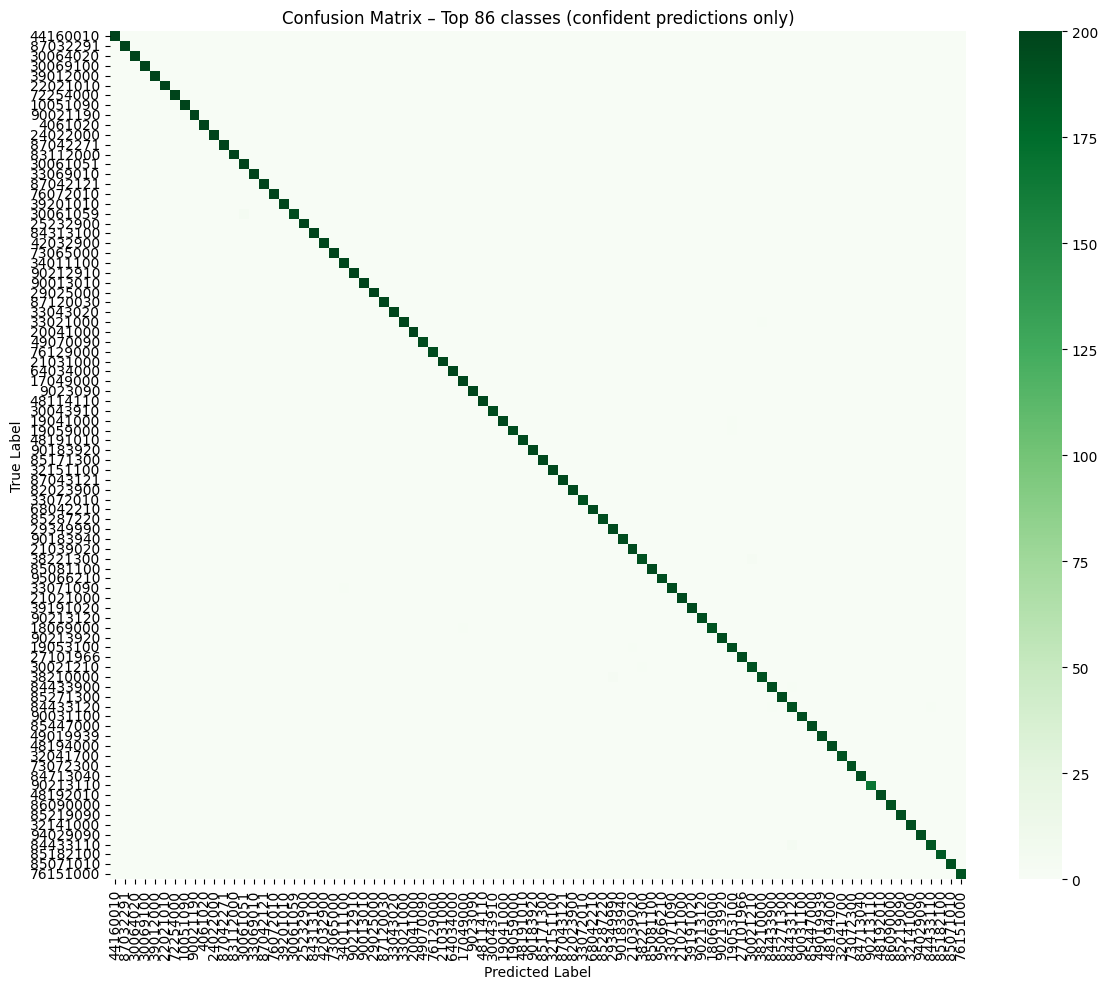

In [ ]:
mask_conf = SVM_pred_labels_abstain != "UNSURE"
y_true = SVM_y_val[mask_conf]
y_pred = SVM_pred_labels_abstain[mask_conf]

print("Matriz de Confusión SVM")
print(" - Casos totales:", len(SVM_y_val))
print(" - Casos confiables:", len(y_true))
print(" - Coverage:", len(y_true) / len(SVM_y_val))

# Top-N clases por soporte en y_true
TOPN = int(svm_n_classes * 0.2)
top_classes = y_true.value_counts().head(TOPN).index.tolist()

cm_top = confusion_matrix(y_true, y_pred, labels=top_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_top,
    annot=False,
    cmap="Greens",
    xticklabels=top_classes,
    yticklabels=top_classes,
    cbar=True
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix – Top {TOPN} classes (confident predictions only)")
plt.tight_layout()
plt.show()


In [ ]:
# probar varios umbrales y elegir el que maximiza accuracy en predicciones confiables
taus = np.linspace(0.0, 2.0, 51)

best = None
for tau in taus:
    pred = SVM_pred_labels.copy()
    pred[SVM_margin < tau] = "UNSURE"
    mask = pred != "UNSURE"
    if mask.mean() < 0.5:
        continue  # evita quedarse con muy pocas predicciones
    acc_tau = accuracy_score(SVM_y_val[mask], pred[mask]) # Corregido: usar 'mask' en ambos argumentos
    cov = mask.mean()  # coverage: fracción de casos clasificados
    # objetivo: alta accuracy con cobertura razonable
    score = acc_tau * 0.7 + cov * 0.3
    cand = (tau, acc_tau, cov, score)
    if (best is None) or (cand[3] > best[3]):
        best = cand

print("[OK] Mejor TAU_MARGIN:", best[0])
print("[INFO] accuracy_confiable:", best[1], "| coverage:", best[2])


[OK] Mejor TAU_MARGIN: 0.52
[INFO] accuracy_confiable: 0.955738853007548 | coverage: 0.7471511627906977
